In [1]:
# 1. Imports
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# 2. Load and clean metadata CSV
df = pd.read_csv("Data_Entry_2017.csv")
df = df[["Image Index", "Finding Labels"]]
df = df.rename(columns={"Image Index": "image", "Finding Labels": "labels"})

# Optional: limit to first 5000 entries for faster training
df = df.head(5000)

# Filter only available images
image_dir = "images"
available_images = set(os.listdir(image_dir))
df = df[df["image"].isin(available_images)]
df = df.reset_index(drop=True)
print(f"{len(df)} images matched and kept.")

# Split multi-labels into list
df["labels"] = df["labels"].apply(lambda x: x.split("|"))

# Fit the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["labels"])
label_classes = mlb.classes_
print("Labels:", list(label_classes))


5000 images matched and kept.
Labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
# 3. Define PyTorch Dataset
class XrayDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.df = dataframe
        self.img_dir = image_folder
        self.transform = transform
        self.labels = mlb.transform(dataframe["labels"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]["image"])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label


In [6]:
# 4. Data transforms and DataLoader
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = XrayDataset(df, image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print("Total samples:", len(dataset))


Total samples: 5000


In [ ]:
!pip install torchvision


In [19]:
import torchvision.models as models

# Load pretrained ResNet18
resnet = models.resnet18(pretrained=True)

# Modify the input for grayscale images (1 channel instead of 3)
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final layer to output the correct number of labels
num_labels = len(label_classes)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_labels)

model = resnet.to(device)


C:\Users\asus\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asus\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ✅ Define your model class with dynamic flattening
class SimpleCNN(nn.Module):
    def __init__(self, num_labels=14, input_size=(128, 128)):  # Set to your image size
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Dynamically calculate the flatten size based on input image size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_size)  # Batch size 1, grayscale
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flatten_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, num_labels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Create model
model = SimpleCNN(num_labels=15).to(device)

# ✅ Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ Training loop (replace `dataloader` with your actual DataLoader)
for epoch in range(20):  # increase for better training
    model.train()
    running_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss:.4f}")

# ✅ Save model for future use
torch.save(model.state_dict(), "simple_cnn_model.pth")
print("📦 Model saved as simple_cnn_model.pth")


Epoch 1, Loss: 68.9065
Epoch 2, Loss: 64.8354
Epoch 3, Loss: 63.7482
Epoch 4, Loss: 62.0490
Epoch 5, Loss: 60.2716
Epoch 6, Loss: 58.2040
Epoch 7, Loss: 55.0784
Epoch 8, Loss: 50.9443
Epoch 9, Loss: 45.8225
Epoch 10, Loss: 40.0135
Epoch 11, Loss: 33.5221
Epoch 12, Loss: 27.1906
Epoch 13, Loss: 21.3907
Epoch 14, Loss: 16.2229
Epoch 15, Loss: 11.9435
Epoch 16, Loss: 8.5971
Epoch 17, Loss: 6.6077
Epoch 18, Loss: 4.7994
Epoch 19, Loss: 3.4287
Epoch 20, Loss: 2.9697
📦 Model saved as simple_cnn_model.pth


In [28]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ----- SETTINGS -----
test_folder = "test_images"
metadata_path = "Data_Entry_2017.csv"
model_path = "simple_cnn_model.pth"
image_size = (128, 128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- LABELS (15 classes with "No Finding") -----
label_classes = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
    "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia", "No Finding"
]

# ----- TRANSFORM -----
test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ----- ENCODE LABELS -----
def encode_labels(label_str):
    labels = label_str.split("|")
    if "No Finding" in labels:
        return [0]*14 + [1]
    return [1 if cls in labels else 0 for cls in label_classes]

# ----- MODEL DEFINITION -----
class SimpleCNN(nn.Module):
    def __init__(self, num_labels=15, input_size=(128, 128)):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_size)
            x = self.pool(torch.relu(self.conv1(dummy_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            self.flatten_size = x.view(1, -1).shape[1]
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, num_labels)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----- LOAD MODEL -----
model = SimpleCNN(num_labels=15, input_size=image_size).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("✅ Model loaded.")

# ----- LOAD METADATA -----
df = pd.read_csv(metadata_path)
df.set_index("Image Index", inplace=True)

# ----- EVALUATION -----
y_true = []
y_pred = []
threshold = 0.02 # adjust if needed

for fname in os.listdir(test_folder):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue
    if fname not in df.index:
        print(f"⚠️ {fname} not in metadata, skipping.")
        continue

    try:
        labels = encode_labels(df.loc[fname, "Finding Labels"])
        img_path = os.path.join(test_folder, fname)
        img = Image.open(img_path).convert("L")
        img_tensor = test_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.sigmoid(output).cpu().numpy()[0]

        pred = (probs > threshold).astype(int)
        if len(pred) != 15:
            print(f"❌ Skipping {fname}: output size mismatch.")
            continue

        y_true.append(labels)
        y_pred.append(pred)

    except Exception as e:
        print(f"⚠️ Error processing {fname}: {e}")

# ----- METRICS -----
if len(y_true) == 0:
    print("🚫 No valid test images were evaluated.")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n📊 Classification Report (including 'No Finding'):")
    print(classification_report(y_true, y_pred, target_names=label_classes, zero_division=0))

    print(f"\n✅ Micro Accuracy:   {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Micro Precision: {precision_score(y_true, y_pred, average='micro'):.4f}")
    print(f"✅ Micro Recall:    {recall_score(y_true, y_pred, average='micro'):.4f}")
    print(f"✅ Micro F1 Score:  {f1_score(y_true, y_pred, average='micro'):.4f}")


✅ Model loaded.

📊 Classification Report (including 'No Finding'):
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00         1
      Cardiomegaly       0.00      0.00      0.00         0
          Effusion       0.00      0.00      0.00         1
      Infiltration       0.00      0.00      0.00         0
              Mass       0.00      0.00      0.00         1
            Nodule       0.00      0.00      0.00         0
         Pneumonia       0.00      0.00      0.00         0
      Pneumothorax       0.00      0.00      0.00         0
     Consolidation       0.00      0.00      0.00         0
             Edema       0.00      0.00      0.00         0
         Emphysema       0.00      0.00      0.00         0
          Fibrosis       0.00      0.00      0.00         0
Pleural_Thickening       0.00      0.00      0.00         2
            Hernia       0.00      0.00      0.00         0
        No Finding       1.00   

In [7]:
from PIL import Image
import torchvision.transforms as transforms

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Same size as training
    transforms.ToTensor()
])



📂 File: 00003876_004.png
🧠 Predicted labels: ['Emphysema']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.000
Emphysema: 0.113
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


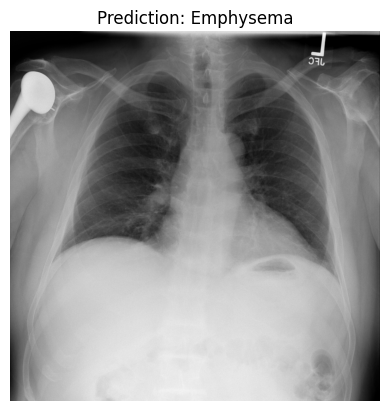


📂 File: 00003877_000.png
🧠 Predicted labels: ['Edema']
📊 Probabilities:
Atelectasis: 0.036
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.012
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 1.000
Emphysema: 0.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.014


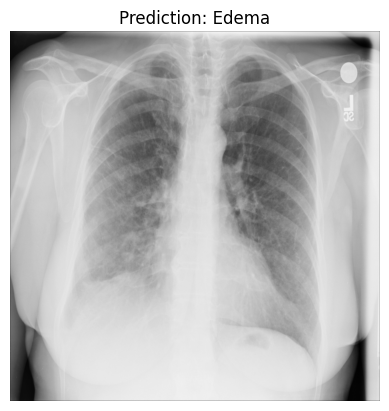


📂 File: 00003877_001.png
🧠 Predicted labels: ['Emphysema']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.000
Emphysema: 1.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


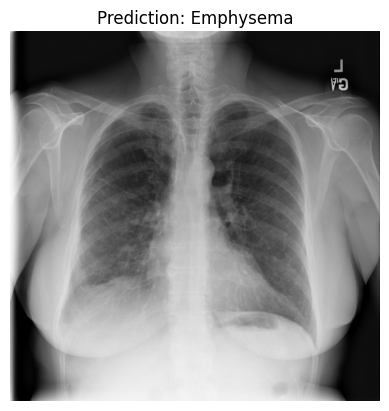


📂 File: 00003877_002.png
🧠 Predicted labels: ['Emphysema']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.000
Emphysema: 0.998
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


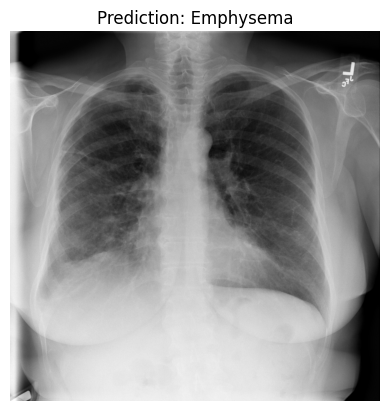


📂 File: 00003877_003.png
🧠 Predicted labels: ['Nodule', 'Edema']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 1.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 1.000
Emphysema: 0.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


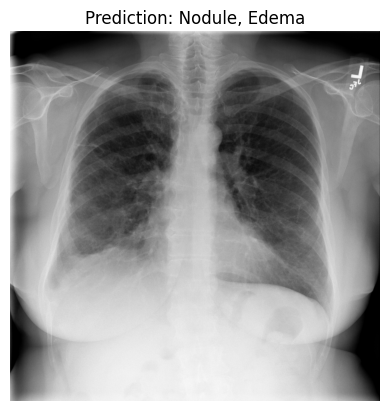


📂 File: 00003878_000.png
🧠 Predicted labels: ['Emphysema']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.000
Emphysema: 0.886
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


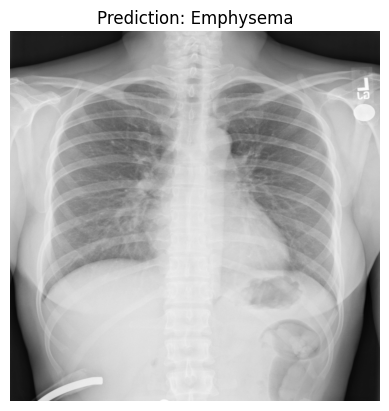


📂 File: 00003879_000.png
🧠 Predicted labels: []
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.000
Emphysema: 0.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


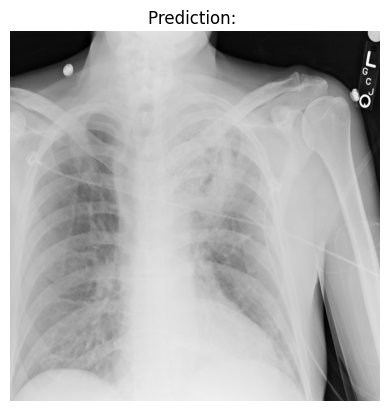


📂 File: 00003879_001.png
🧠 Predicted labels: ['Emphysema']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.000
Emphysema: 1.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


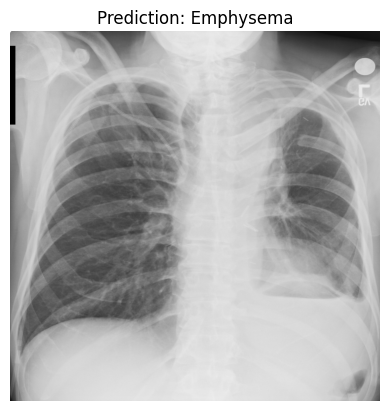


📂 File: 00003879_002.png
🧠 Predicted labels: ['Emphysema']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.000
Emphysema: 1.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


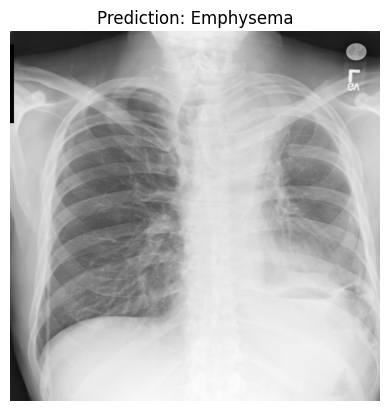


📂 File: 00003880_000.png
🧠 Predicted labels: ['Nodule']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 1.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.002
Emphysema: 0.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


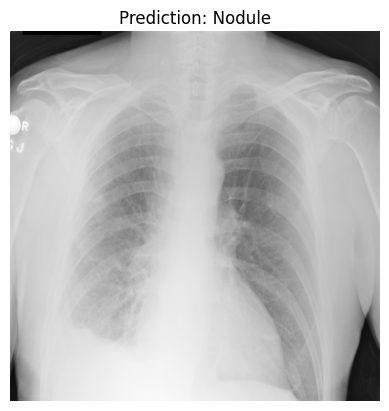


📂 File: 00003880_001.png
🧠 Predicted labels: []
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 0.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.095
Edema: 0.000
Emphysema: 0.003
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 0.000


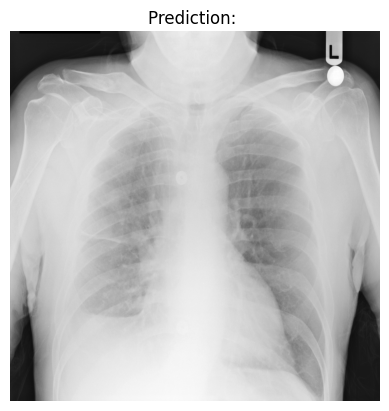


📂 File: 00003880_002.png
🧠 Predicted labels: ['Nodule', 'Edema', 'No Finding']
📊 Probabilities:
Atelectasis: 0.000
Cardiomegaly: 0.000
Effusion: 0.000
Infiltration: 0.000
Mass: 0.000
Nodule: 1.000
Pneumonia: 0.000
Pneumothorax: 0.000
Consolidation: 0.000
Edema: 0.883
Emphysema: 0.000
Fibrosis: 0.000
Pleural_Thickening: 0.000
Hernia: 0.000
No Finding: 1.000


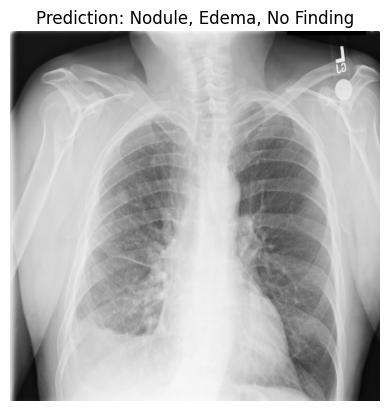

In [29]:
import os
from PIL import Image
import matplotlib.pyplot as plt

test_folder = "test_images"
threshold = 0.1  # adjust for sensitivity

for fname in os.listdir(test_folder):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    path = os.path.join(test_folder, fname)
    try:
        # Load and transform image
        img = Image.open(path).convert("L")
        img_tensor = test_transform(img).unsqueeze(0).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.sigmoid(output).cpu().numpy()[0]

        # Get predicted labels
        predicted = [label_classes[i] for i, p in enumerate(probs) if p > threshold]

        # 📄 Print and show results
        print(f"\n📂 File: {fname}")
        print("🧠 Predicted labels:", predicted)
        print("📊 Probabilities:")
        for i, p in enumerate(probs):
            print(f"{label_classes[i]}: {p:.3f}")

        # 🖼️ Show image
        plt.imshow(img, cmap="gray")
        plt.title("Prediction: " + ", ".join(predicted))
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"⚠️ Error with {fname}: {e}")


In [30]:
import os
import pandas as pd
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Paths
test_folder = "test_images"
metadata_path = "Data_Entry_2017.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label classes
label_classes = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
    "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

# Transform for test images
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Prediction threshold
threshold = 0.1

# Load NIH metadata
df = pd.read_csv(metadata_path)
df = df[["Image Index", "Finding Labels"]]
df.set_index("Image Index", inplace=True)

# Encode label string to binary vector
def encode_labels(label_str):
    labels = label_str.split("|")
    return [1 if cls in labels else 0 for cls in label_classes]

# Lists to store results
y_true = []
y_pred = []

# Loop through test images
for fname in os.listdir(test_folder):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    if fname not in df.index:
        print(f"⚠️ Skipping {fname}: not found in metadata.")
        continue

    try:
        # Get ground truth labels
        label_str = df.loc[fname, "Finding Labels"]
        true_vector = encode_labels(label_str)

        if len(true_vector) != len(label_classes):
            print(f"❌ Skipping {fname}: ground truth label length mismatch.")
            continue

        # Load and preprocess image
        img_path = os.path.join(test_folder, fname)
        img = Image.open(img_path).convert("L")
        img_tensor = test_transform(img).unsqueeze(0).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.sigmoid(output).cpu().numpy()[0]

        pred_vector = (probs > threshold).astype(int)

        if len(pred_vector) != len(label_classes):
            print(f"❌ Skipping {fname}: prediction length mismatch.")
            continue

        y_true.append(true_vector)
        y_pred.append(pred_vector)

    except Exception as e:
        print(f"⚠️ Error processing {fname}: {e}")

# Check if we have valid data
if len(y_true) == 0 or len(y_pred) == 0:
    print("\n🚫 No valid samples processed. Please check your test_images folder and CSV labels.")
else:
    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Show how many images were evaluated
    print(f"\n✅ Processed {len(y_true)} images successfully.")

    # Compute metrics
    print("\n🔍 Classification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=label_classes,
        zero_division=0
    ))

    print(f"\n📈 Micro Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"📌 Micro Precision: {precision_score(y_true, y_pred, average='micro'):.4f}")
    print(f"📌 Micro Recall: {recall_score(y_true, y_pred, average='micro'):.4f}")
    print(f"📌 Micro F1-score: {f1_score(y_true, y_pred, average='micro'):.4f}")


⚠️ Error processing 00003876_004.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003877_000.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003877_001.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003877_002.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003877_003.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003878_000.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003879_000.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003879_001.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003879_002.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error processing 00003880_000.png: mat1 and mat2 sha

In [31]:
import os
from PIL import Image

test_folder = "test_images"
results = []

for fname in os.listdir(test_folder):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
        continue  # skip non-image files

    path = os.path.join(test_folder, fname)
    try:
        img = Image.open(path).convert("L")
        img_tensor = test_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.sigmoid(output).cpu().numpy()[0]

        threshold = 0.1  # adjust if needed
        predicted = [label_classes[i] for i, p in enumerate(probs) if p > threshold]

        results.append({
            "filename": fname,
            "predictions": ", ".join(predicted),
            **{label_classes[i]: round(p, 3) for i, p in enumerate(probs)}
        })
    except Exception as e:
        print(f"⚠️ Error with {fname}: {e}")


⚠️ Error with 00003876_004.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003877_000.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003877_001.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003877_002.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003877_003.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003878_000.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003879_000.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003879_001.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003879_002.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error with 00003880_000.png: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x128)
⚠️ Error w

In [10]:
import pandas as pd

df_results = pd.DataFrame(results)

In [44]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results.to_csv("xray_predictions.csv", index=False)
print("✅ Saved predictions to xray_predictions.csv")


✅ Saved predictions to xray_predictions.csv


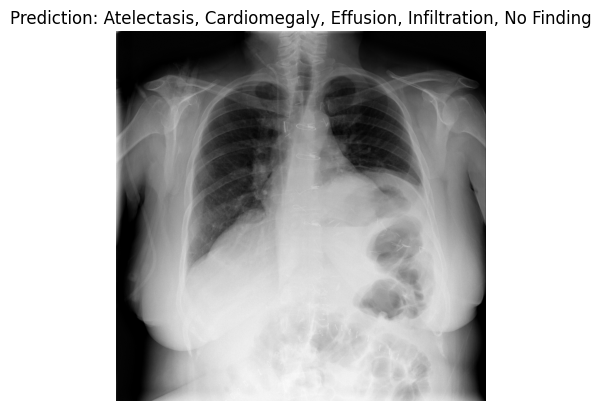

Atelectasis: 0.334
Cardiomegaly: 0.113
Consolidation: 0.073
Edema: 0.025
Effusion: 0.325
Emphysema: 0.022
Fibrosis: 0.059
Hernia: 0.028
Infiltration: 0.226
Mass: 0.042
No Finding: 0.310
Nodule: 0.029
Pleural_Thickening: 0.050
Pneumonia: 0.017
Pneumothorax: 0.040


In [41]:
# model.eval()
# with torch.no_grad():
#     output = model(img_tensor)
#     probs = torch.sigmoid(output).cpu().numpy()[0]

# threshold = 0.1  # can adjust to 0.3 or 0.5
# predicted_labels = [label_classes[i] for i, p in enumerate(probs) if p > threshold]

# # Display
# import matplotlib.pyplot as plt

# plt.imshow(img, cmap="gray")
# plt.title("Prediction: " + ", ".join(predicted_labels))
# plt.axis("off")
# plt.show()

# # Optional: print scores
# for i, p in enumerate(probs):
#     print(f"{label_classes[i]}: {p:.3f}")


Predicted labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


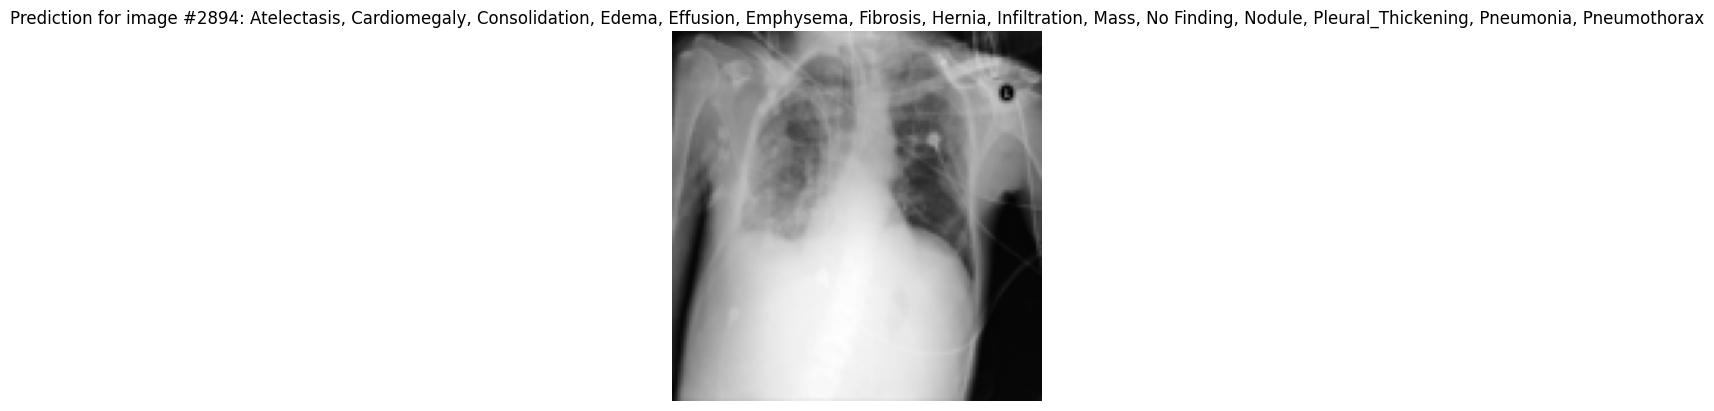

Atelectasis: 0.500
Cardiomegaly: 0.366
Consolidation: 0.502
Edema: 0.460
Effusion: 0.597
Emphysema: 0.466
Fibrosis: 0.528
Hernia: 0.508
Infiltration: 0.392
Mass: 0.477
No Finding: 0.524
Nodule: 0.479
Pleural_Thickening: 0.552
Pneumonia: 0.597
Pneumothorax: 0.498


In [11]:
import random

idx = random.randint(0, len(dataset) - 1)
img, true_label = dataset[idx]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = torch.sigmoid(pred).cpu().numpy()[0]

threshold = 0.1
predicted_labels = [label_classes[i] for i, p in enumerate(pred) if p > threshold]
print("Predicted labels:", predicted_labels)

plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Prediction for image #{idx}: " + ", ".join(predicted_labels))
plt.axis("off")
plt.show()

for i, p in enumerate(pred):
    print(f"{label_classes[i]}: {p:.3f}")

